# Xarray Fundamentals

**Attribution**: This notebook is a revision of the Xarray Fundamentals [notebook](https://earth-env-data-science.github.io/lectures/xarray/xarray.html) by Ryan Abernathy from [An Introduction to Earth and Environmental Data Science](https://earth-env-data-science.github.io/intro.html).

In this lecture, we will have a deep dive to `xarray` package. So far in this class, we have used `rioxarray` for raster data processing, and `stackstac` for analyzing stacks of satellite imagery. Both of these packages are built on top of `xarray`; however, we didn't use all the functionalities of `xarray` with them. 

We also worked with `xarray` `DataArray` and `Dataset` after reading data from different sources. Here, we will learn how to create a `DataArray` or `Dataset` from scratch.

In the previous lecture on Raster Data Processing, we introduced `Dataset` in `rioxarray` and discussed how it is different from `DataArray`. Here we will have a complete review of data structures in `xarray`:

## Xarray data structures

Like Pandas, xarray has two fundamental data structures:
* a `DataArray`, which holds a single multi-dimensional variable and its coordinates
* a `Dataset`, which holds multiple variables that potentially share the same coordinates

### DataArray

A `DataArray` has four essential attributes:
* `values`: a `numpy.ndarray` holding the array’s values
* `dims`: dimension names for each axis (e.g., `('x', 'y', 'z')`)
* `coords`: a dict-like container of arrays (coordinates) that label each point (e.g., 1-dimensional arrays of numbers, datetime objects or strings)
* `attrs`: an `OrderedDict` to hold arbitrary metadata (attributes)

Let's start by constructing some DataArrays manually 

In [1]:
import numpy as np
import xarray as xr
from matplotlib import pyplot as plt

A simple DataArray without dimensions or coordinates isn't much use.

In [2]:
da = xr.DataArray([9, 0, 2, 1, 0])
da

<xarray.DataArray (dim_0: 5)>
array([9, 0, 2, 1, 0])
Dimensions without coordinates: dim_0

We can add a dimension name...

In [3]:
da = xr.DataArray([9, 0, 2, 1, 0], dims=['x'])
da

<xarray.DataArray (x: 5)>
array([9, 0, 2, 1, 0])
Dimensions without coordinates: x

But things get most interesting when we add a coordinate:

In [4]:
da = xr.DataArray([9, 0, 2, 1, 0],
                  dims=['x'],
                  coords={'x': [10, 20, 30, 40, 50]})
da

<xarray.DataArray (x: 5)>
array([9, 0, 2, 1, 0])
Coordinates:
  * x        (x) int64 10 20 30 40 50

This coordinate has been used to create an _index_, which works very similar to a Pandas index.
In fact, under the hood, Xarray just reuses Pandas indexes.

In [5]:
da.indexes

Indexes:
    x        Index([10, 20, 30, 40, 50], dtype='int64', name='x')

Xarray has built-in plotting, like pandas.

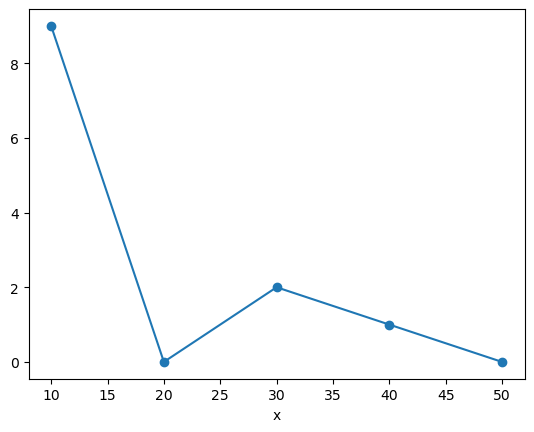

In [6]:
da.plot(marker='o')

### Multidimensional DataArray

If we are just dealing with 1D data, Pandas and Xarray have very similar capabilities. Xarray's real potential comes with multidimensional data.

In this example, we use real data from ocean profiling floats. [ARGO](https://www.aoml.noaa.gov/argo/) floats are autonomous robotic instruments that collect *Temperature, Salinity, and Pressure* data from the ocean. ARGO floats collect one “profile” (a set of messurements at different depths or “levels”).

<div>
<center>
<img src="https://argo.ucsd.edu/wp-content/uploads/sites/361/2020/06/float_cycle_1.png" width="800"/>
</div>

Each profile has a single latitude, longitude, and date associated with it, in addition to many different levels.

Let’s start by using [pooch](https://www.fatiando.org/pooch/latest/) to download the data files we need for this exercise. The following code will give you a list of `.npy` files that you can open in the next step.



``` {Note}
You see that we are passing a hash to the retrieve method from `pooch` here. Hash-based verification ensures that a file has not been corrupted by comparing the file's hash value to a previously calculated value. If these values match, the file is presumed to be unmodified.
```

In [7]:
import pooch
url = "https://www.ldeo.columbia.edu/~rpa/float_data_4901412.zip"
files = pooch.retrieve(url, processor=pooch.Unzip(), known_hash="2a703c720302c682f1662181d329c9f22f9f10e1539dc2d6082160a469165009")
files.sort()
files

['/home/jovyan/.cache/pooch/7e6685dbe2a3c0b0870f770f3ef413d9-float_data_4901412.zip.unzip/float_data/P.npy',
 '/home/jovyan/.cache/pooch/7e6685dbe2a3c0b0870f770f3ef413d9-float_data_4901412.zip.unzip/float_data/S.npy',
 '/home/jovyan/.cache/pooch/7e6685dbe2a3c0b0870f770f3ef413d9-float_data_4901412.zip.unzip/float_data/T.npy',
 '/home/jovyan/.cache/pooch/7e6685dbe2a3c0b0870f770f3ef413d9-float_data_4901412.zip.unzip/float_data/date.npy',
 '/home/jovyan/.cache/pooch/7e6685dbe2a3c0b0870f770f3ef413d9-float_data_4901412.zip.unzip/float_data/lat.npy',
 '/home/jovyan/.cache/pooch/7e6685dbe2a3c0b0870f770f3ef413d9-float_data_4901412.zip.unzip/float_data/levels.npy',
 '/home/jovyan/.cache/pooch/7e6685dbe2a3c0b0870f770f3ef413d9-float_data_4901412.zip.unzip/float_data/lon.npy']

We will manually load each of these variables into a numpy array.
If this seems repetitive and inefficient, that's the point!
NumPy itself is not meant for managing groups of inter-related arrays.
That's what Xarray is for!

In [8]:
P = np.load(files[0])
S = np.load(files[1])
T = np.load(files[2])
date = np.load(files[3])
lat = np.load(files[4])
levels = np.load(files[5])
lon = np.load(files[6])

Let's look at the shape of some of the variables:

In [9]:
print("Salinity shape is:", S.shape)
print("Levels shape is:", levels.shape)
print("Date shape is:", date.shape)

Salinity shape is: (78, 75)
Levels shape is: (78,)
Date shape is: (75,)


As expected, Salinity has dimensions of levels x date

Let's organize the data and coordinates of the salinity variable into a DataArray.

In [10]:
da_salinity = xr.DataArray(S, dims=['level', 'date'],
                           coords={'level': levels,
                                   'date': date},)
da_salinity

<xarray.DataArray (level: 78, date: 75)>
array([[35.6389389 , 35.51495743, 35.57297134, ..., 35.82093811,
        35.77793884, 35.66891098],
       [35.63393784, 35.5219574 , 35.57397079, ..., 35.81093216,
        35.58389664, 35.66791153],
       [35.6819458 , 35.52595901, 35.57297134, ..., 35.79592896,
        35.66290665, 35.66591263],
       ...,
       [34.91585922, 34.92390442, 34.92390442, ..., 34.93481064,
        34.94081116, 34.94680786],
       [34.91585922, 34.92390442, 34.92190552, ..., 34.93280792,
        34.93680954, 34.94380951],
       [34.91785812, 34.92390442, 34.92390442, ...,         nan,
        34.93680954,         nan]])
Coordinates:
  * level    (level) int64 0 1 2 3 4 5 6 7 8 9 ... 68 69 70 71 72 73 74 75 76 77
  * date     (date) datetime64[ns] 2012-07-13T22:33:06.019200 ... 2014-07-24T...

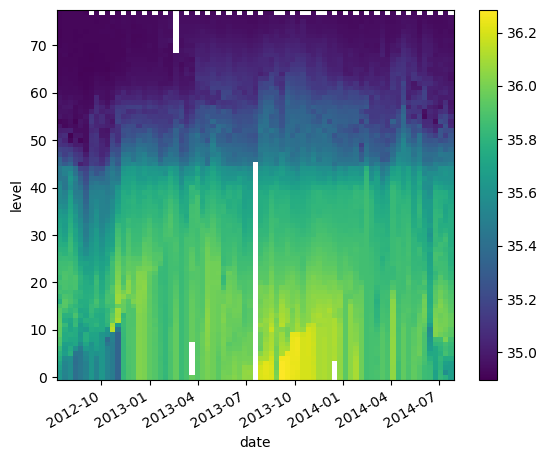

In [11]:
da_salinity.plot()

Since we are working with ocean data, it's helpful to plot the `level` in an increasing order from top to bottom:

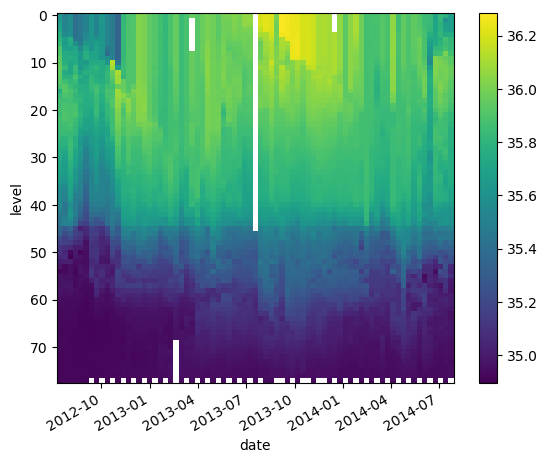

In [12]:
da_salinity.plot(yincrease=False)

Attributes can be used to store metadata. What metadata should you store? The [CF Conventions](http://cfconventions.org/Data/cf-conventions/cf-conventions-1.7/cf-conventions.html#_description_of_the_data) are a great resource for thinking about climate metadata. Below we define two of the required CF-conventions attributes.

In [13]:
da_salinity.attrs['units'] = 'PSU'
da_salinity.attrs['standard_name'] = 'sea_water_salinity'
da_salinity

<xarray.DataArray (level: 78, date: 75)>
array([[35.6389389 , 35.51495743, 35.57297134, ..., 35.82093811,
        35.77793884, 35.66891098],
       [35.63393784, 35.5219574 , 35.57397079, ..., 35.81093216,
        35.58389664, 35.66791153],
       [35.6819458 , 35.52595901, 35.57297134, ..., 35.79592896,
        35.66290665, 35.66591263],
       ...,
       [34.91585922, 34.92390442, 34.92390442, ..., 34.93481064,
        34.94081116, 34.94680786],
       [34.91585922, 34.92390442, 34.92190552, ..., 34.93280792,
        34.93680954, 34.94380951],
       [34.91785812, 34.92390442, 34.92390442, ...,         nan,
        34.93680954,         nan]])
Coordinates:
  * level    (level) int64 0 1 2 3 4 5 6 7 8 9 ... 68 69 70 71 72 73 74 75 76 77
  * date     (date) datetime64[ns] 2012-07-13T22:33:06.019200 ... 2014-07-24T...
Attributes:
    units:          PSU
    standard_name:  sea_water_salinity

Now if we plot the data again, the name and units are automatically attached to the figure.

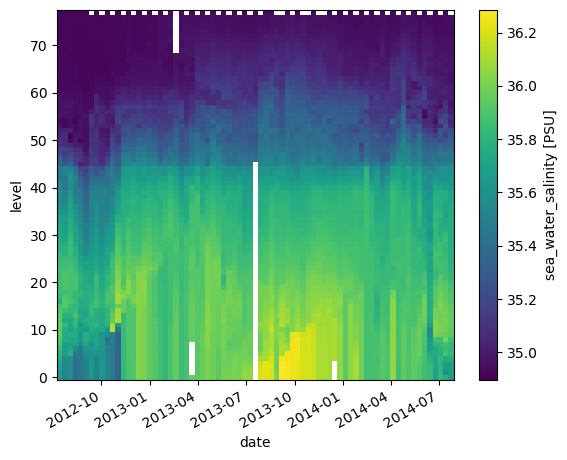

In [14]:
da_salinity.plot()

### Datasets

A Dataset holds many DataArrays which potentially can share coordinates. In analogy to pandas:

    pandas.Series : pandas.Dataframe :: xarray.DataArray : xarray.Dataset
    
Constructing Datasets manually is a bit more involved in terms of syntax. The Dataset constructor takes three arguments:

* `data_vars` should be a dictionary with each key as the name of the variable and each value as one of:
  * A `DataArray` or Variable
  * A tuple of the form `(dims, data[, attrs])`, which is converted into arguments for Variable
  * A pandas object, which is converted into a `DataArray`
  * A 1D array or list, which is interpreted as values for a one dimensional coordinate variable along the same dimension as it’s name
* `coords` should be a dictionary of the same form as data_vars.
* `attrs` should be a dictionary.

Let's put together a Dataset with temperature, salinity and pressure all together

In [15]:
argo = xr.Dataset(
    data_vars={
        'salinity':    (('level', 'date'), S),
        'temperature': (('level', 'date'), T),
        'pressure':    (('level', 'date'), P)
    },
    coords={
        'level': levels,
        'date': date
    }
)
argo

<xarray.Dataset>
Dimensions:      (level: 78, date: 75)
Coordinates:
  * level        (level) int64 0 1 2 3 4 5 6 7 8 ... 69 70 71 72 73 74 75 76 77
  * date         (date) datetime64[ns] 2012-07-13T22:33:06.019200 ... 2014-07...
Data variables:
    salinity     (level, date) float64 35.64 35.51 35.57 35.4 ... nan 34.94 nan
    temperature  (level, date) float64 18.97 18.44 19.1 19.79 ... nan 3.714 nan
    pressure     (level, date) float64 6.8 6.1 6.5 5.0 ... 2e+03 nan 2e+03 nan

What about lon and lat? We forgot them in the creation process, but we can add them after the fact.

In [16]:
argo.coords['lon'] = lon
argo

<xarray.Dataset>
Dimensions:      (level: 78, date: 75, lon: 75)
Coordinates:
  * level        (level) int64 0 1 2 3 4 5 6 7 8 ... 69 70 71 72 73 74 75 76 77
  * date         (date) datetime64[ns] 2012-07-13T22:33:06.019200 ... 2014-07...
  * lon          (lon) float64 -39.13 -37.28 -36.9 ... -33.83 -34.11 -34.38
Data variables:
    salinity     (level, date) float64 35.64 35.51 35.57 35.4 ... nan 34.94 nan
    temperature  (level, date) float64 18.97 18.44 19.1 19.79 ... nan 3.714 nan
    pressure     (level, date) float64 6.8 6.1 6.5 5.0 ... 2e+03 nan 2e+03 nan

That was not quite right...we want lon to have dimension `date`:

In [17]:
del argo['lon']
argo.coords['lon'] = ('date', lon)
argo.coords['lat'] = ('date', lat)
argo

<xarray.Dataset>
Dimensions:      (level: 78, date: 75)
Coordinates:
  * level        (level) int64 0 1 2 3 4 5 6 7 8 ... 69 70 71 72 73 74 75 76 77
  * date         (date) datetime64[ns] 2012-07-13T22:33:06.019200 ... 2014-07...
    lon          (date) float64 -39.13 -37.28 -36.9 ... -33.83 -34.11 -34.38
    lat          (date) float64 47.19 46.72 46.45 46.23 ... 42.6 42.46 42.38
Data variables:
    salinity     (level, date) float64 35.64 35.51 35.57 35.4 ... nan 34.94 nan
    temperature  (level, date) float64 18.97 18.44 19.1 19.79 ... nan 3.714 nan
    pressure     (level, date) float64 6.8 6.1 6.5 5.0 ... 2e+03 nan 2e+03 nan

### Coordinates vs. Data Variables

Data variables can be modified through arithmentic operations or other functions. Coordinates are always keept the same.

In [18]:
argo * 10000

<xarray.Dataset>
Dimensions:      (level: 78, date: 75)
Coordinates:
  * level        (level) int64 0 1 2 3 4 5 6 7 8 ... 69 70 71 72 73 74 75 76 77
  * date         (date) datetime64[ns] 2012-07-13T22:33:06.019200 ... 2014-07...
    lon          (date) float64 -39.13 -37.28 -36.9 ... -33.83 -34.11 -34.38
    lat          (date) float64 47.19 46.72 46.45 46.23 ... 42.6 42.46 42.38
Data variables:
    salinity     (level, date) float64 3.564e+05 3.551e+05 ... 3.494e+05 nan
    temperature  (level, date) float64 1.897e+05 1.844e+05 ... 3.714e+04 nan
    pressure     (level, date) float64 6.8e+04 6.1e+04 6.5e+04 ... nan 2e+07 nan

Clearly lon and lat are coordinates rather than data variables.

The bold font in the representation above indicates that `level` and `date` are "dimension coordinates" (they describe the coordinates associated with data variable axes) while `lon` and `lat` are "non-dimension coordinates". We can make any variable a non-dimension coordiante (using `set_coords`).

## Selecting Data (Indexing)

We can always use regular numpy indexing and slicing on DataArrays

In [19]:
argo.salinity.shape

(78, 75)

In [20]:
argo.salinity[2]

<xarray.DataArray 'salinity' (date: 75)>
array([35.6819458 , 35.52595901, 35.57297134, 35.40494537, 35.45091629,
       35.50192261, 35.62397766, 35.51696014, 35.62797546, 35.52292252,
       35.47383118, 35.33785629, 35.81896591, 35.88694   , 35.90187836,
       36.02391815, 36.00475693, 35.94187927, 35.91583252, 35.86392212,
       35.81995392, 35.88601303, 35.95079422, 35.84091568, 35.87992477,
               nan, 35.92179108, 35.96979141, 36.0008316 , 35.98083115,
       35.92887878, 35.98091888, 35.9838829 , 36.01884842, 35.99092484,
       36.04689026, 36.04185867,         nan, 36.19193268, 36.22789764,
       36.20986557, 35.97589874, 36.2779007 , 36.25889969, 36.2418251 ,
       36.23685837, 36.19781876, 36.19785309, 36.17692184, 36.1048851 ,
       36.11392212, 36.09080505,         nan, 36.05675888, 35.93374634,
       36.04291534, 36.10183716, 35.97779083, 35.86592102, 35.87791824,
       35.88392258, 35.92078781, 35.88601303, 36.05178833, 35.85883713,
       35.94878769, 35.8938446 , 35.94379425, 35.90884018, 35.84893036,
       35.83496857, 35.71691132, 35.79592896, 35.66290665, 35.66591263])
Coordinates:
    level    int64 2
  * date     (date) datetime64[ns] 2012-07-13T22:33:06.019200 ... 2014-07-24T...
    lon      (date) float64 -39.13 -37.28 -36.9 -36.89 ... -33.83 -34.11 -34.38
    lat      (date) float64 47.19 46.72 46.45 46.23 ... 42.72 42.6 42.46 42.38

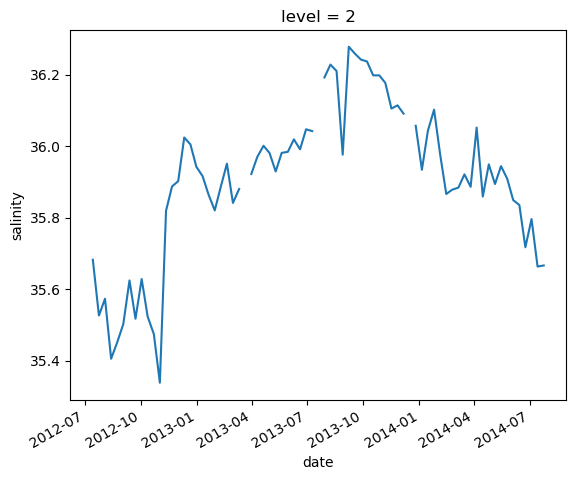

In [21]:
argo.salinity[2].plot()

In [22]:
argo.salinity[:, 10]

<xarray.DataArray 'salinity' (level: 78)>
array([35.47483063, 35.47483063, 35.47383118, 35.47383118, 35.47383118,
       35.47483063, 35.48183441, 35.47983551, 35.4948349 , 35.51083755,
       36.13380051, 36.09579849, 35.95479965, 35.93979645, 35.8958931 ,
       35.86388397, 35.87788773, 35.88188934, 35.90379333, 35.9067955 ,
       35.86588669, 35.8588829 , 35.86088181, 35.85188293, 35.85788345,
       35.82787323, 35.78786469, 35.73185349, 35.69784927, 35.67684174,
       35.677845  , 35.65784073, 35.64083481, 35.6238327 , 35.59682846,
       35.57782364, 35.56182098, 35.55781937, 35.52181625, 35.49881363,
       35.51381302, 35.49981308, 35.47280884, 35.47880936, 35.44780731,
       35.39379501, 35.35879135, 35.28778076, 35.21878052, 35.20677567,
       35.17777252, 35.15076828, 35.07276535, 35.01475525, 34.9797554 ,
       35.0117569 , 35.03975677, 35.05575562, 35.00975037, 34.96175385,
       34.96775055, 34.95075226, 34.93775177, 34.93375015, 34.93775558,
       34.9247551 , 34.92175674, 34.91975403, 34.91975403, 34.91975403,
       34.92176056, 34.92375946, 34.92575836, 34.92575836, 34.92475891,
       34.93076324, 34.92176437,         nan])
Coordinates:
  * level    (level) int64 0 1 2 3 4 5 6 7 8 9 ... 68 69 70 71 72 73 74 75 76 77
    date     datetime64[ns] 2012-10-22T02:50:32.006400
    lon      float64 -32.97
    lat      float64 44.13

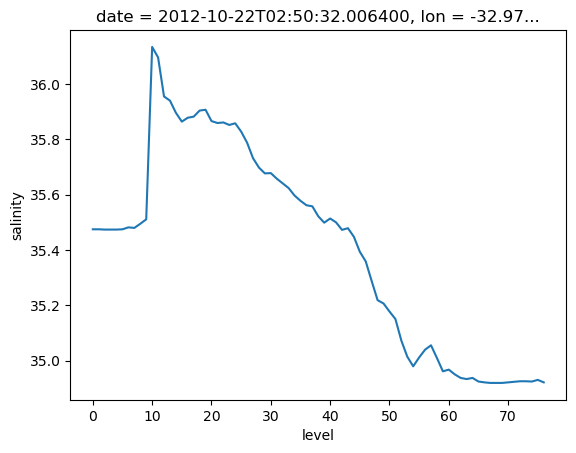

In [46]:
argo.salinity[:, 10:11].plot()

However, it is often much more powerful to use xarray's `.sel()` method to use label-based indexing.

In [47]:
argo.salinity.sel(level=[2, 5])

<xarray.DataArray 'salinity' (level: 2, date: 75)>
array([[35.6819458 , 35.52595901, 35.57297134, 35.40494537, 35.45091629,
        35.50192261, 35.62397766, 35.51696014, 35.62797546, 35.52292252,
        35.47383118, 35.33785629, 35.81896591, 35.88694   , 35.90187836,
        36.02391815, 36.00475693, 35.94187927, 35.91583252, 35.86392212,
        35.81995392, 35.88601303, 35.95079422, 35.84091568, 35.87992477,
                nan, 35.92179108, 35.96979141, 36.0008316 , 35.98083115,
        35.92887878, 35.98091888, 35.9838829 , 36.01884842, 35.99092484,
        36.04689026, 36.04185867,         nan, 36.19193268, 36.22789764,
        36.20986557, 35.97589874, 36.2779007 , 36.25889969, 36.2418251 ,
        36.23685837, 36.19781876, 36.19785309, 36.17692184, 36.1048851 ,
        36.11392212, 36.09080505,         nan, 36.05675888, 35.93374634,
        36.04291534, 36.10183716, 35.97779083, 35.86592102, 35.87791824,
        35.88392258, 35.92078781, 35.88601303, 36.05178833, 35.85883713,
        35.94878769, 35.8938446 , 35.94379425, 35.90884018, 35.84893036,
        35.83496857, 35.71691132, 35.79592896, 35.66290665, 35.66591263],
       [35.7889595 , 35.67097855, 35.77500153, 35.4429512 , 35.44491196,
        35.55392838, 35.62497711, 35.59697342, 35.62897873, 35.52292252,
        35.47483063, 35.33785629, 35.81996536, 35.88993835, 35.90187836,
        36.02191925, 36.00475693, 35.93987656, 35.91583633, 35.86492538,
        35.81995773, 35.8870163 , 35.95079422, 35.84191513, 35.87992477,
                nan, 35.92179108, 35.96479034, 36.00683594, 35.98083115,
        35.9368782 , 35.99091721, 35.962883  , 35.98684311, 35.97792435,
        35.98988724, 35.97084808,         nan, 36.0339241 , 36.09988785,
        36.15286255, 35.98789215, 36.11489487, 36.24489975, 36.24282455,
        36.24985886, 36.19781876, 36.19885254, 36.17592239, 36.10388565,
        36.11192322, 36.09080505, 36.11088181, 36.05976105, 35.93475342,
        36.04491425, 36.08283615, 35.97679138, 35.86592102, 35.87791824,
        35.88392258, 35.92078781, 35.88500977, 36.0527916 , 35.87383652,
        35.9487915 , 35.8938446 , 35.9407959 , 35.97483444, 35.87393188,
        35.73094177, 35.73391342, 35.77991486, 35.87294388, 35.8139267 ]])
Coordinates:
  * level    (level) int64 2 5
  * date     (date) datetime64[ns] 2012-07-13T22:33:06.019200 ... 2014-07-24T...
    lon      (date) float64 -39.13 -37.28 -36.9 -36.89 ... -33.83 -34.11 -34.38
    lat      (date) float64 47.19 46.72 46.45 46.23 ... 42.72 42.6 42.46 42.38

In [24]:
argo.salinity.sel(level=2)

<xarray.DataArray 'salinity' (date: 75)>
array([35.6819458 , 35.52595901, 35.57297134, 35.40494537, 35.45091629,
       35.50192261, 35.62397766, 35.51696014, 35.62797546, 35.52292252,
       35.47383118, 35.33785629, 35.81896591, 35.88694   , 35.90187836,
       36.02391815, 36.00475693, 35.94187927, 35.91583252, 35.86392212,
       35.81995392, 35.88601303, 35.95079422, 35.84091568, 35.87992477,
               nan, 35.92179108, 35.96979141, 36.0008316 , 35.98083115,
       35.92887878, 35.98091888, 35.9838829 , 36.01884842, 35.99092484,
       36.04689026, 36.04185867,         nan, 36.19193268, 36.22789764,
       36.20986557, 35.97589874, 36.2779007 , 36.25889969, 36.2418251 ,
       36.23685837, 36.19781876, 36.19785309, 36.17692184, 36.1048851 ,
       36.11392212, 36.09080505,         nan, 36.05675888, 35.93374634,
       36.04291534, 36.10183716, 35.97779083, 35.86592102, 35.87791824,
       35.88392258, 35.92078781, 35.88601303, 36.05178833, 35.85883713,
       35.94878769, 35.8938446 , 35.94379425, 35.90884018, 35.84893036,
       35.83496857, 35.71691132, 35.79592896, 35.66290665, 35.66591263])
Coordinates:
    level    int64 2
  * date     (date) datetime64[ns] 2012-07-13T22:33:06.019200 ... 2014-07-24T...
    lon      (date) float64 -39.13 -37.28 -36.9 -36.89 ... -33.83 -34.11 -34.38
    lat      (date) float64 47.19 46.72 46.45 46.23 ... 42.72 42.6 42.46 42.38

Under the hood, this method is powered by using pandas’s powerful Index objects which means this method uses pandas’s (well documented) logic for indexing. For example, you can use string shortcuts for datetime indexes (e.g., ‘2000-01’ to select all values in January 2000). It also means that slices are treated as inclusive of both the start and stop values, unlike normal Python indexing.


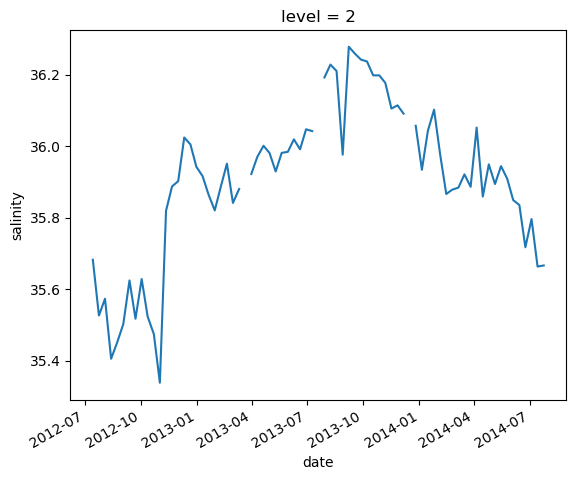

In [25]:
argo.salinity.sel(level=2).plot()

In [26]:
argo.salinity.sel(date='2012-10-22')

<xarray.DataArray 'salinity' (level: 78, date: 1)>
array([[35.47483063],
       [35.47483063],
       [35.47383118],
       [35.47383118],
       [35.47383118],
       [35.47483063],
       [35.48183441],
       [35.47983551],
       [35.4948349 ],
       [35.51083755],
       [36.13380051],
       [36.09579849],
       [35.95479965],
       [35.93979645],
       [35.8958931 ],
       [35.86388397],
       [35.87788773],
       [35.88188934],
       [35.90379333],
       [35.9067955 ],
...
       [35.00975037],
       [34.96175385],
       [34.96775055],
       [34.95075226],
       [34.93775177],
       [34.93375015],
       [34.93775558],
       [34.9247551 ],
       [34.92175674],
       [34.91975403],
       [34.91975403],
       [34.91975403],
       [34.92176056],
       [34.92375946],
       [34.92575836],
       [34.92575836],
       [34.92475891],
       [34.93076324],
       [34.92176437],
       [        nan]])
Coordinates:
  * level    (level) int64 0 1 2 3 4 5 6 7 8 9 ... 68 69 70 71 72 73 74 75 76 77
  * date     (date) datetime64[ns] 2012-10-22T02:50:32.006400
    lon      (date) float64 -32.97
    lat      (date) float64 44.13

We can improve the plot by using the `yincrease` argument, and setting the variable that will be plotted on `y` axis:

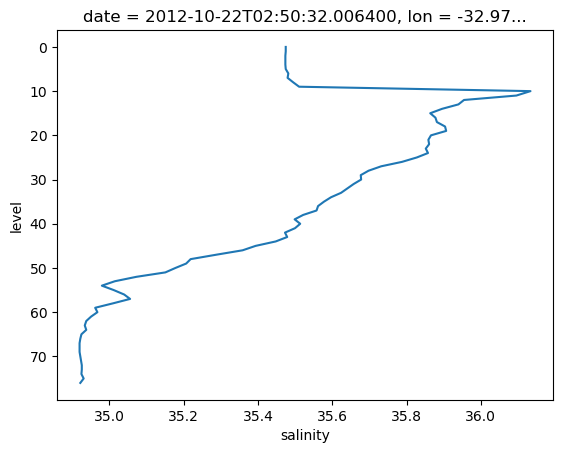

In [27]:
argo.salinity.sel(date='2012-10-22').plot(y='level', yincrease=False)

`.sel()` also supports slicing. Unfortunately we have to use a somewhat awkward syntax, but it still works.

In [28]:
argo.salinity.sel(date=slice('2012-10-01', '2012-12-01'))

<xarray.DataArray 'salinity' (level: 78, date: 7)>
array([[35.63097763, 35.52592468, 35.47483063, 35.33785629, 35.81896591,
        35.8889389 , 35.90187836],
       [35.63097763, 35.52292252, 35.47483063, 35.33685684, 35.81796646,
        35.88793945, 35.90187836],
       [35.62797546, 35.52292252, 35.47383118, 35.33785629, 35.81896591,
        35.88694   , 35.90187836],
       [35.62697601, 35.52192307, 35.47383118, 35.33785629, 35.81896591,
        35.89193726, 35.90187836],
       [35.62797546, 35.52192307, 35.47383118, 35.33785629, 35.81996536,
        35.88993835, 35.90187836],
       [35.62897873, 35.52292252, 35.47483063, 35.33785629, 35.81996536,
        35.88993835, 35.90187836],
       [35.62997818, 35.51892471, 35.48183441, 35.33785629, 35.81996536,
        35.88993835, 35.90187836],
       [35.63197708, 35.44991302, 35.47983551, 35.33785629, 35.81996536,
        35.89683914, 35.90187836],
       [35.63097763, 35.38090134, 35.4948349 , 35.33785629, 35.81896591,
        35.89583969, 35.90187836],
       [35.62697601, 35.58792114, 35.51083755, 35.33985519, 35.82497025,
        35.89683914, 35.90187836],
...
       [34.91690445, 34.92385483, 34.91975403, 34.91980362, 34.92385483,
        34.93680573, 34.93885422],
       [34.92190552, 34.92485428, 34.91975403, 34.92080688, 34.92485428,
        34.94480515, 34.9328537 ],
       [34.92390442, 34.92285538, 34.92176056, 34.92280579, 34.92985535,
        34.93280411, 34.92785645],
       [34.92390442, 34.92385483, 34.92375946, 34.92480469, 34.92685318,
        34.93780899, 34.92485428],
       [34.92390442, 34.92285538, 34.92575836, 34.92181015, 34.92085648,
        34.93680954, 34.92385483],
       [34.92590332, 34.9288559 , 34.92575836, 34.92181015, 34.92685318,
        34.93481064, 34.92585373],
       [34.92490387, 34.92785645, 34.92475891, 34.92781067, 34.93385696,
        34.93380737, 34.92385864],
       [34.92190552, 34.92385864, 34.93076324, 34.9268074 , 34.93585968,
        34.93481064, 34.92985916],
       [34.92090607, 34.92185974, 34.92176437, 34.9228096 , 34.93285751,
        34.93180847, 34.92786026],
       [        nan, 34.91985703,         nan, 34.92181015,         nan,
        34.92181015,         nan]])
Coordinates:
  * level    (level) int64 0 1 2 3 4 5 6 7 8 9 ... 68 69 70 71 72 73 74 75 76 77
  * date     (date) datetime64[ns] 2012-10-02T03:00:17.971200 ... 2012-12-01T...
    lon      (date) float64 -34.46 -33.78 -32.97 -32.55 -32.43 -32.29 -32.17
    lat      (date) float64 44.96 44.68 44.13 43.64 43.07 42.66 42.51

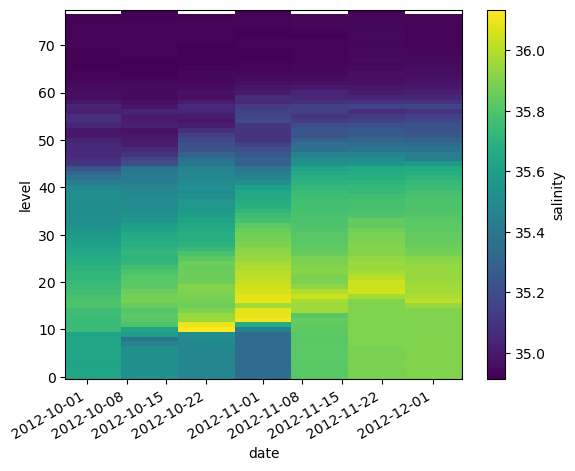

In [29]:
argo.salinity.sel(date=slice('2012-10-01', '2012-12-01')).plot()

`.sel()` also works on the whole Dataset

In [30]:
argo.sel(date='2012-10-22')

<xarray.Dataset>
Dimensions:      (level: 78, date: 1)
Coordinates:
  * level        (level) int64 0 1 2 3 4 5 6 7 8 ... 69 70 71 72 73 74 75 76 77
  * date         (date) datetime64[ns] 2012-10-22T02:50:32.006400
    lon          (date) float64 -32.97
    lat          (date) float64 44.13
Data variables:
    salinity     (level, date) float64 35.47 35.47 35.47 ... 34.93 34.92 nan
    temperature  (level, date) float64 17.13 17.13 17.13 ... 3.736 3.639 nan
    pressure     (level, date) float64 6.4 10.3 15.4 ... 1.9e+03 1.951e+03 nan

In [74]:
argo.sel(date = '2012-12-22')

<xarray.Dataset>
Dimensions:      (level: 78, date: 0)
Coordinates:
  * level        (level) int64 0 1 2 3 4 5 6 7 8 ... 69 70 71 72 73 74 75 76 77
  * date         (date) datetime64[ns] 
    lon          (date) float64 
    lat          (date) float64 
Data variables:
    salinity     (level, date) float64 
    temperature  (level, date) float64 
    pressure     (level, date) float64

## Computation

`Xarray` `DataArrays` and `Datasets` work seamlessly with arithmetic operators and numpy array functions.

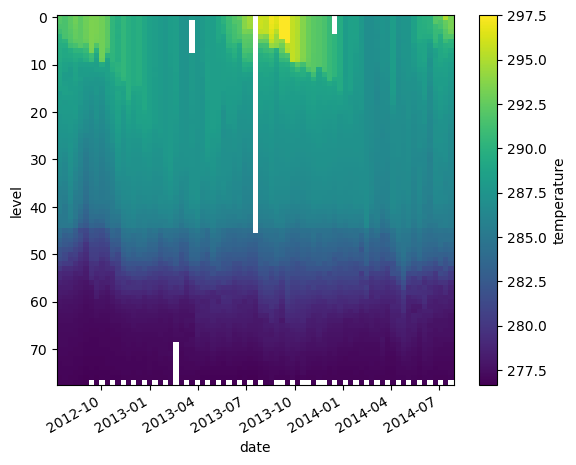

In [31]:
temp_kelvin = argo.temperature + 273.15
temp_kelvin.plot(yincrease=False)

We can also combine multiple `xarray` datasets in arithemtic operations

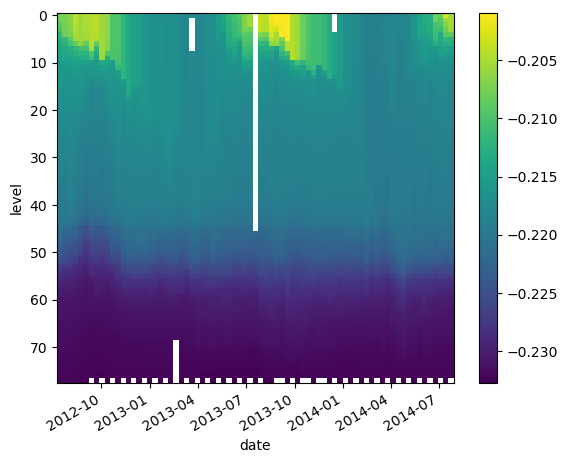

In [32]:
g = 9.8
buoyancy = g * (2e-4 * argo.temperature - 7e-4 * argo.salinity)
buoyancy.plot(yincrease=False)

## Broadcasting, Aligment, and Combining Data

### Broadcasting

Broadcasting arrays in numpy is a nightmare. It is much easier when the data axes are labeled!

This is a useless calculation, but it illustrates how perfoming an operation on arrays with differenty coordinates will result in automatic broadcasting

In [33]:
argo.level

<xarray.DataArray 'level' (level: 78)>
array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
       36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53,
       54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71,
       72, 73, 74, 75, 76, 77])
Coordinates:
  * level    (level) int64 0 1 2 3 4 5 6 7 8 9 ... 68 69 70 71 72 73 74 75 76 77

In [34]:
argo.lat

<xarray.DataArray 'lat' (date: 75)>
array([47.187, 46.716, 46.45 , 46.23 , 45.459, 44.833, 44.452, 44.839,
       44.956, 44.676, 44.13 , 43.644, 43.067, 42.662, 42.513, 42.454,
       42.396, 42.256, 42.089, 41.944, 41.712, 41.571, 41.596, 41.581,
       41.351, 41.032, 40.912, 40.792, 40.495, 40.383, 40.478, 40.672,
       41.032, 40.864, 40.651, 40.425, 40.228, 40.197, 40.483, 40.311,
       40.457, 40.463, 40.164, 40.047, 39.963, 40.122, 40.57 , 40.476,
       40.527, 40.589, 40.749, 40.993, 41.162, 41.237, 41.448, 41.65 ,
       42.053, 42.311, 42.096, 41.683, 41.661, 41.676, 42.018, 42.395,
       42.532, 42.558, 42.504, 42.63 , 42.934, 42.952, 42.777, 42.722,
       42.601, 42.457, 42.379])
Coordinates:
  * date     (date) datetime64[ns] 2012-07-13T22:33:06.019200 ... 2014-07-24T...
    lon      (date) float64 -39.13 -37.28 -36.9 -36.89 ... -33.83 -34.11 -34.38
    lat      (date) float64 47.19 46.72 46.45 46.23 ... 42.72 42.6 42.46 42.38

In [35]:
level_times_lat = argo.level * argo.lat
level_times_lat

<xarray.DataArray (level: 78, date: 75)>
array([[   0.   ,    0.   ,    0.   , ...,    0.   ,    0.   ,    0.   ],
       [  47.187,   46.716,   46.45 , ...,   42.601,   42.457,   42.379],
       [  94.374,   93.432,   92.9  , ...,   85.202,   84.914,   84.758],
       ...,
       [3539.025, 3503.7  , 3483.75 , ..., 3195.075, 3184.275, 3178.425],
       [3586.212, 3550.416, 3530.2  , ..., 3237.676, 3226.732, 3220.804],
       [3633.399, 3597.132, 3576.65 , ..., 3280.277, 3269.189, 3263.183]])
Coordinates:
  * level    (level) int64 0 1 2 3 4 5 6 7 8 9 ... 68 69 70 71 72 73 74 75 76 77
  * date     (date) datetime64[ns] 2012-07-13T22:33:06.019200 ... 2014-07-24T...
    lon      (date) float64 -39.13 -37.28 -36.9 -36.89 ... -33.83 -34.11 -34.38
    lat      (date) float64 47.19 46.72 46.45 46.23 ... 42.72 42.6 42.46 42.38

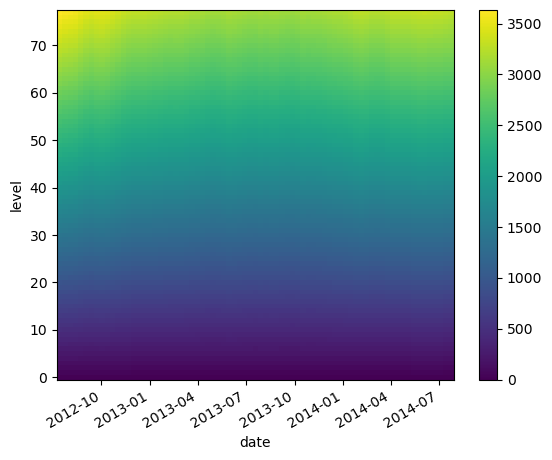

In [36]:
level_times_lat.plot()

### Alignment

If you try to perform operations on `DataArrays` that share a dimension name, `Xarray` will try to _align_ them first.
This works nearly identically to `Pandas`, except that there can be multiple dimensions to align over.

To see how alignment works, we will create some subsets of our original data.

In [37]:
sa_surf = argo.salinity.isel(level=slice(0, 20))
sa_mid = argo.salinity.isel(level=slice(10, 30))

By default, when we combine multiple arrays in mathematical operations, `Xarray` performs an "inner join".

In [38]:
(sa_surf * sa_mid).level

<xarray.DataArray 'level' (level: 10)>
array([10, 11, 12, 13, 14, 15, 16, 17, 18, 19])
Coordinates:
  * level    (level) int64 10 11 12 13 14 15 16 17 18 19

We can override this behavior by manually aligning the data

In [39]:
sa_surf_outer, sa_mid_outer = xr.align(sa_surf, sa_mid, join='outer')
sa_surf_outer

<xarray.DataArray 'salinity' (level: 30, date: 75)>
array([[35.6389389 , 35.51495743, 35.57297134, ..., 35.82093811,
        35.77793884, 35.66891098],
       [35.63393784, 35.5219574 , 35.57397079, ..., 35.81093216,
        35.58389664, 35.66791153],
       [35.6819458 , 35.52595901, 35.57297134, ..., 35.79592896,
        35.66290665, 35.66591263],
       ...,
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan]])
Coordinates:
  * level    (level) int64 0 1 2 3 4 5 6 7 8 9 ... 20 21 22 23 24 25 26 27 28 29
  * date     (date) datetime64[ns] 2012-07-13T22:33:06.019200 ... 2014-07-24T...
    lon      (date) float64 -39.13 -37.28 -36.9 -36.89 ... -33.83 -34.11 -34.38
    lat      (date) float64 47.19 46.72 46.45 46.23 ... 42.72 42.6 42.46 42.38

As we can see, missing data (NaNs) have been filled in where the array was extended. 

From the documentation: Missing values (if `join != 'inner'`) are filled with `fill_value`. The default fill value is NaN.

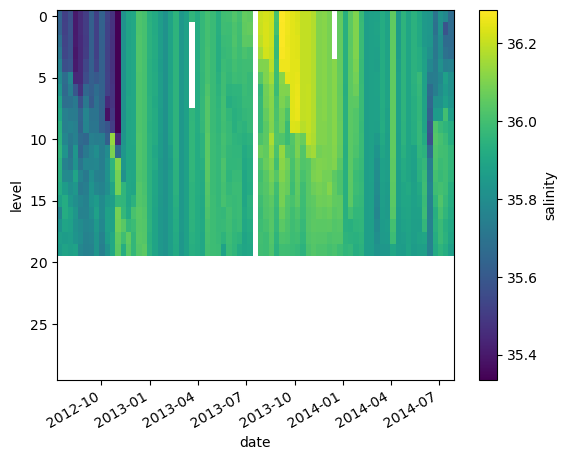

In [40]:
sa_surf_outer.plot(yincrease=False)

We can also use `join='right'` and `join='left'`.

If we run our multiplication on the aligned data:

In [48]:
(sa_surf_outer * sa_mid_outer).level

<xarray.DataArray 'level' (level: 30)>
array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29])
Coordinates:
  * level    (level) int64 0 1 2 3 4 5 6 7 8 9 ... 20 21 22 23 24 25 26 27 28 29

### Combing Data: Concat and Merge

The ability to combine many smaller arrays into a single big Dataset is one of the main advantages of `Xarray`.
To take advantage of this, we need to learn two operations that help us combine data:
- `xr.contact`: to concatenate multiple arrays into one bigger array along their dimensions
- `xr.merge`: to combine multiple different arrays into a dataset

First let's look at concat. Let's re-combine the subsetted data from the previous step.

In [49]:
sa_surf_mid = xr.concat([sa_surf, sa_mid], dim='level')
sa_surf_mid

<xarray.DataArray 'salinity' (level: 40, date: 75)>
array([[35.6389389 , 35.51495743, 35.57297134, ..., 35.82093811,
        35.77793884, 35.66891098],
       [35.63393784, 35.5219574 , 35.57397079, ..., 35.81093216,
        35.58389664, 35.66791153],
       [35.6819458 , 35.52595901, 35.57297134, ..., 35.79592896,
        35.66290665, 35.66591263],
       ...,
       [35.78895187, 35.7829895 , 35.85100555, ..., 35.84291458,
        35.81891251, 35.7779007 ],
       [35.76794815, 35.75598526, 35.84500504, ..., 35.84891891,
        35.83391571, 35.76390076],
       [35.75194168, 35.71097565, 35.83100128, ..., 35.80690765,
        35.85292053, 35.75489807]])
Coordinates:
  * level    (level) int64 0 1 2 3 4 5 6 7 8 9 ... 20 21 22 23 24 25 26 27 28 29
  * date     (date) datetime64[ns] 2012-07-13T22:33:06.019200 ... 2014-07-24T...
    lon      (date) float64 -39.13 -37.28 -36.9 -36.89 ... -33.83 -34.11 -34.38
    lat      (date) float64 47.19 46.72 46.45 46.23 ... 42.72 42.6 42.46 42.38

```{warning}
Xarray won't check the values of the coordinates before `concat`. It will just stick everything together into a new array.
```

In this case, we had overlapping data. We can see this by looking at the `level` coordinate.

In [50]:
sa_surf_mid.level

<xarray.DataArray 'level' (level: 40)>
array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25,
       26, 27, 28, 29])
Coordinates:
  * level    (level) int64 0 1 2 3 4 5 6 7 8 9 ... 20 21 22 23 24 25 26 27 28 29

In [52]:
sa_surf_mid.sel(level=11)

<xarray.DataArray 'salinity' (level: 2, date: 75)>
array([[35.95887756, 35.82500458, 35.70597839, 35.8350029 , 35.64592743,
        35.71894073, 35.76799011, 35.80199432, 35.7379837 , 35.79395294,
        36.09579849, 35.6628952 , 35.83797073, 35.89783859, 35.89887619,
        36.02391815, 36.00475693, 35.94387817, 35.90093613, 35.85692215,
        35.81895828, 35.86300659, 35.94979477, 35.84291458, 35.87992477,
        35.95978928, 35.92179108, 35.94578934, 36.04083633, 35.98183441,
        35.96687317, 35.99791718, 35.96387863, 35.9588356 , 35.95691681,
        35.91187668, 35.93383408,         nan, 36.06692123, 36.05187607,
        36.12983704, 36.01087952, 36.13287735, 36.02987671, 36.01980209,
        36.09484482, 36.02880096, 36.13484573, 36.15492249, 36.08387756,
        36.09292221, 36.09080505, 36.10988235, 36.05976105, 35.9327507 ,
        36.04291534, 36.01783371, 35.97879028, 35.86592102, 35.87792206,
        35.82791138, 35.89588547, 35.86800766, 36.05178833, 35.87783432,
        35.9337883 , 35.8938446 , 35.88488388, 35.95883179, 35.94283676,
        35.67092896, 36.02183533, 35.99683762, 35.9948349 , 35.96183395],
       [35.95887756, 35.82500458, 35.70597839, 35.8350029 , 35.64592743,
        35.71894073, 35.76799011, 35.80199432, 35.7379837 , 35.79395294,
        36.09579849, 35.6628952 , 35.83797073, 35.89783859, 35.89887619,
        36.02391815, 36.00475693, 35.94387817, 35.90093613, 35.85692215,
        35.81895828, 35.86300659, 35.94979477, 35.84291458, 35.87992477,
        35.95978928, 35.92179108, 35.94578934, 36.04083633, 35.98183441,
        35.96687317, 35.99791718, 35.96387863, 35.9588356 , 35.95691681,
        35.91187668, 35.93383408,         nan, 36.06692123, 36.05187607,
        36.12983704, 36.01087952, 36.13287735, 36.02987671, 36.01980209,
        36.09484482, 36.02880096, 36.13484573, 36.15492249, 36.08387756,
        36.09292221, 36.09080505, 36.10988235, 36.05976105, 35.9327507 ,
        36.04291534, 36.01783371, 35.97879028, 35.86592102, 35.87792206,
        35.82791138, 35.89588547, 35.86800766, 36.05178833, 35.87783432,
        35.9337883 , 35.8938446 , 35.88488388, 35.95883179, 35.94283676,
        35.67092896, 36.02183533, 35.99683762, 35.9948349 , 35.96183395]])
Coordinates:
  * level    (level) int64 11 11
  * date     (date) datetime64[ns] 2012-07-13T22:33:06.019200 ... 2014-07-24T...
    lon      (date) float64 -39.13 -37.28 -36.9 -36.89 ... -33.83 -34.11 -34.38
    lat      (date) float64 47.19 46.72 46.45 46.23 ... 42.72 42.6 42.46 42.38

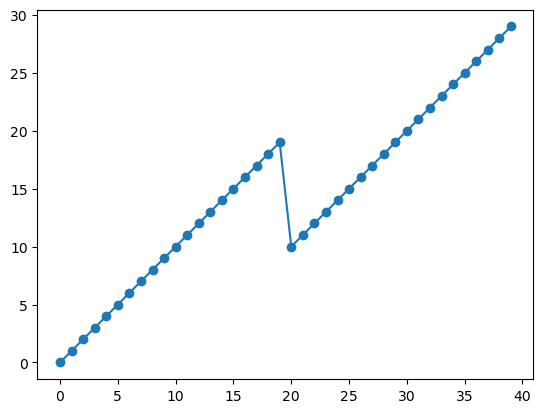

In [51]:
plt.plot(sa_surf_mid.level.values, marker='o')

We can also concat data along a _new_ dimension, e.g.

In [53]:
sa_concat_new = xr.concat([sa_surf, sa_mid], dim='newdim')
sa_concat_new

<xarray.DataArray 'salinity' (newdim: 2, level: 30, date: 75)>
array([[[35.6389389 , 35.51495743, 35.57297134, ..., 35.82093811,
         35.77793884, 35.66891098],
        [35.63393784, 35.5219574 , 35.57397079, ..., 35.81093216,
         35.58389664, 35.66791153],
        [35.6819458 , 35.52595901, 35.57297134, ..., 35.79592896,
         35.66290665, 35.66591263],
        ...,
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan]],

       [[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        ...,
        [35.78895187, 35.7829895 , 35.85100555, ..., 35.84291458,
         35.81891251, 35.7779007 ],
        [35.76794815, 35.75598526, 35.84500504, ..., 35.84891891,
         35.83391571, 35.76390076],
        [35.75194168, 35.71097565, 35.83100128, ..., 35.80690765,
         35.85292053, 35.75489807]]])
Coordinates:
  * level    (level) int64 0 1 2 3 4 5 6 7 8 9 ... 20 21 22 23 24 25 26 27 28 29
  * date     (date) datetime64[ns] 2012-07-13T22:33:06.019200 ... 2014-07-24T...
    lon      (date) float64 -39.13 -37.28 -36.9 -36.89 ... -33.83 -34.11 -34.38
    lat      (date) float64 47.19 46.72 46.45 46.23 ... 42.72 42.6 42.46 42.38
Dimensions without coordinates: newdim

Note that the data were aligned using an _outer_ join along the non-concat dimensions.

We can merge both `DataArrays` and `Datasets`:

In [54]:
xr.merge([argo.salinity, argo.temperature])

<xarray.Dataset>
Dimensions:      (level: 78, date: 75)
Coordinates:
  * level        (level) int64 0 1 2 3 4 5 6 7 8 ... 69 70 71 72 73 74 75 76 77
  * date         (date) datetime64[ns] 2012-07-13T22:33:06.019200 ... 2014-07...
    lon          (date) float64 -39.13 -37.28 -36.9 ... -33.83 -34.11 -34.38
    lat          (date) float64 47.19 46.72 46.45 46.23 ... 42.6 42.46 42.38
Data variables:
    salinity     (level, date) float64 35.64 35.51 35.57 35.4 ... nan 34.94 nan
    temperature  (level, date) float64 18.97 18.44 19.1 19.79 ... nan 3.714 nan

If the data are not aligned, they will be aligned before merge.
We can specify the join options in `merge`.

In [55]:
xr.merge([
    argo.salinity.sel(level=slice(0, 30)),
    argo.temperature.sel(level=slice(30, None))
])

<xarray.Dataset>
Dimensions:      (level: 78, date: 75)
Coordinates:
  * level        (level) int64 0 1 2 3 4 5 6 7 8 ... 69 70 71 72 73 74 75 76 77
  * date         (date) datetime64[ns] 2012-07-13T22:33:06.019200 ... 2014-07...
    lon          (date) float64 -39.13 -37.28 -36.9 ... -33.83 -34.11 -34.38
    lat          (date) float64 47.19 46.72 46.45 46.23 ... 42.6 42.46 42.38
Data variables:
    salinity     (level, date) float64 35.64 35.51 35.57 35.4 ... nan nan nan
    temperature  (level, date) float64 nan nan nan nan ... 3.728 nan 3.714 nan

In [56]:
xr.merge([
    argo.salinity.sel(level=slice(0, 30)),
    argo.temperature.sel(level=slice(30, None))
], join='left')

<xarray.Dataset>
Dimensions:      (level: 31, date: 75)
Coordinates:
  * level        (level) int64 0 1 2 3 4 5 6 7 8 ... 22 23 24 25 26 27 28 29 30
  * date         (date) datetime64[ns] 2012-07-13T22:33:06.019200 ... 2014-07...
    lon          (date) float64 -39.13 -37.28 -36.9 ... -33.83 -34.11 -34.38
    lat          (date) float64 47.19 46.72 46.45 46.23 ... 42.6 42.46 42.38
Data variables:
    salinity     (level, date) float64 35.64 35.51 35.57 ... 35.78 35.83 35.76
    temperature  (level, date) float64 nan nan nan nan ... 13.59 13.74 13.31

## Reductions

Just like in numpy, we can reduce `Xarray` `DataArrays` along any number of axes:

In [57]:
argo.temperature.mean(axis=0)

<xarray.DataArray 'temperature' (date: 75)>
array([10.88915385, 10.7282564 , 10.9336282 , 10.75679484, 10.38166666,
       10.08619236, 10.58194804, 10.50066671, 10.56841555, 10.53705122,
       10.81131168, 11.01932052, 11.39205196, 11.40823073, 11.3642208 ,
       11.35821797, 11.39444157, 11.10514098, 11.02870125, 10.80894868,
       10.93076625, 11.01069231, 11.88195654, 10.57373078, 10.66359736,
       10.56573237, 11.08854546, 10.87921792, 11.21384416, 11.24991028,
       11.29168825, 11.06203848, 11.32829864, 11.20401279, 11.25300001,
       11.32106403, 11.40112986,  6.07053117, 11.7748052 , 11.7466795 ,
       12.03732056, 11.92653251, 12.08844156, 12.20543591, 12.23402598,
       12.03365387, 11.9919221 , 11.92087012, 11.84273071, 11.79711684,
       11.7895325 , 11.55385894, 11.19083561, 11.266282  , 11.0611948 ,
       11.0307179 , 11.06566232, 10.79799995, 10.787     , 10.41173077,
       10.44170127, 10.32649998, 10.38242857, 10.88080769, 10.86177921,
       10.98787178, 10.93602596, 10.73039743, 11.09251948, 10.93983334,
       10.65942862, 11.01814097, 11.21918184, 11.19080765, 11.13364934])
Coordinates:
  * date     (date) datetime64[ns] 2012-07-13T22:33:06.019200 ... 2014-07-24T...
    lon      (date) float64 -39.13 -37.28 -36.9 -36.89 ... -33.83 -34.11 -34.38
    lat      (date) float64 47.19 46.72 46.45 46.23 ... 42.72 42.6 42.46 42.38

In [58]:
argo.temperature.mean(axis=1)

<xarray.DataArray 'temperature' (level: 78)>
array([17.60172602, 17.57223609, 17.5145833 , 17.42326395, 17.24943838,
       17.03730134, 16.76787661, 16.44609588, 16.17439195, 16.04501356,
       15.65827023, 15.4607296 , 15.26114862, 15.12489191, 14.99133783,
       14.90160808, 14.81990544, 14.74535139, 14.66822971, 14.585027  ,
       14.49732434, 14.41904053, 14.35412163, 14.27102702, 14.19081082,
       14.11487838, 14.04347293, 13.98067566, 13.90994595, 13.83274319,
       13.76139196, 13.69836479, 13.62335132, 13.54185131, 13.46647295,
       13.39395946, 13.32541891, 13.25205403, 13.18131082, 13.10233782,
       12.89268916, 12.67795943, 12.4649189 , 12.2178513 , 11.98270268,
       11.1281081 , 10.80430666, 10.49702667, 10.1749066 ,  9.83453334,
        9.48625332,  9.19793334,  8.66010666,  8.12324001,  7.60221333,
        7.15289333,  6.74250667,  6.39543999,  6.04598667,  5.74538665,
        5.48913333,  5.26604001,  5.08768   ,  4.93479998,  4.77769334,
        4.65368   ,  4.54237334,  4.44274664,  4.35933333,  4.2653784 ,
        4.17290539,  4.08902703,  3.99864865,  3.92163514,  3.85617567,
        3.78916217,  3.72950001,  3.66207691])
Coordinates:
  * level    (level) int64 0 1 2 3 4 5 6 7 8 9 ... 68 69 70 71 72 73 74 75 76 77

However, rather than performing reductions on axes (as in numpy), we can perform them on dimensions. This turns out to be a huge convenience

In [59]:
argo_mean = argo.mean(dim='date')
argo_mean

<xarray.Dataset>
Dimensions:      (level: 78)
Coordinates:
  * level        (level) int64 0 1 2 3 4 5 6 7 8 ... 69 70 71 72 73 74 75 76 77
Data variables:
    salinity     (level) float64 35.91 35.9 35.9 35.9 ... 34.94 34.94 34.93
    temperature  (level) float64 17.6 17.57 17.51 17.42 ... 3.789 3.73 3.662
    pressure     (level) float64 6.435 10.57 15.54 ... 1.95e+03 1.999e+03

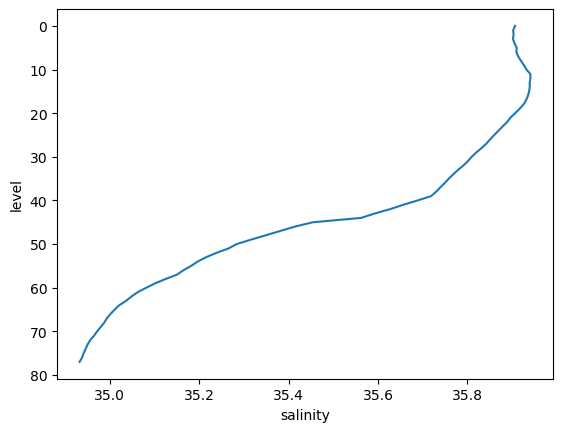

In [60]:
argo_mean.salinity.plot(y='level', yincrease=False)

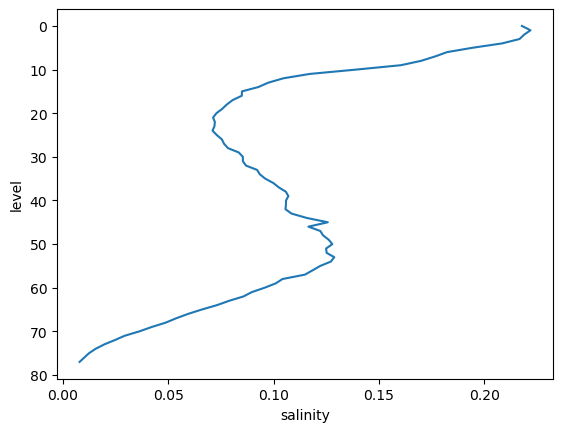

In [61]:
argo_std = argo.std(dim='date')
argo_std.salinity.plot(y='level', yincrease=False)

### Weighted Reductions

Sometimes we want to perform a reduction (e.g. a mean) where we assign different weight factors to each point in the array.
`Xarray` supports this via [weighted array reductions](http://xarray.pydata.org/en/stable/user-guide/computation.html#weighted-array-reductions).

As a toy example, imagine we want to weight values in the upper ocean more than the lower ocean.
We could imagine creating a weight array exponentially proportional to pressure as follows:

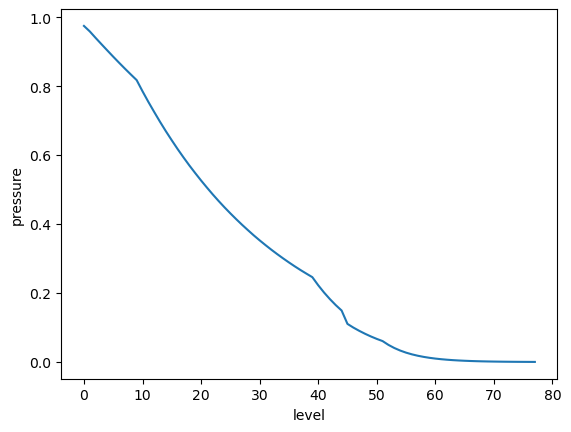

In [62]:
mean_pressure = argo.pressure.mean(dim='date')
p0 = 250
weights = np.exp(-mean_pressure / p0)
weights.plot()

The weighted mean over the `level` dimensions is calculated as follows:

In [63]:
temp_weighted_mean = argo.temperature.weighted(weights).mean(dim='level')

Comparing to the unweighted mean, we see the difference:

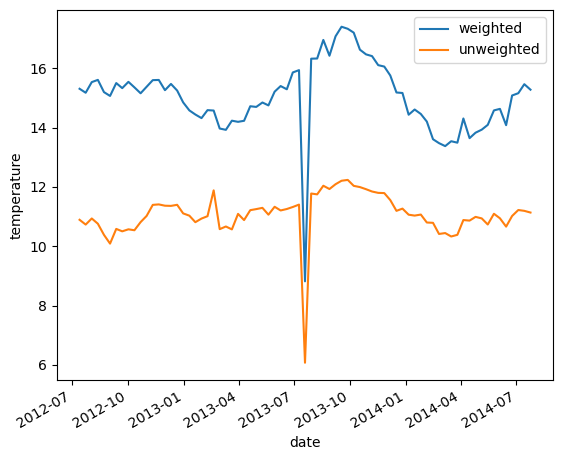

In [64]:
temp_weighted_mean.plot(label='weighted')
argo.temperature.mean(dim='level').plot(label='unweighted')
plt.legend()

## Loading Data from netCDF Files

NetCDF (Network Common Data Format) is the most widely used format for distributing geoscience data. NetCDF is maintained by the [Unidata](https://www.unidata.ucar.edu/) organization.

Below we quote from the [NetCDF website](https://www.unidata.ucar.edu/software/netcdf/docs/faq.html#whatisit):

>NetCDF (network Common Data Form) is a set of interfaces for array-oriented data access and a freely distributed collection of data access libraries for C, Fortran, C++, Java, and other languages. The netCDF libraries support a machine-independent format for representing scientific data. Together, the interfaces, libraries, and format support the creation, access, and sharing of scientific data.
>
>NetCDF data is:
>
> - Self-Describing. A netCDF file includes information about the data it contains.
> - Portable. A netCDF file can be accessed by computers with different ways of storing integers, characters, and floating-point numbers.
> - Scalable. A small subset of a large dataset may be accessed efficiently.
> - Appendable. Data may be appended to a properly structured netCDF file without copying the dataset or redefining its structure.
> - Sharable. One writer and multiple readers may simultaneously access the same netCDF file.
> - Archivable. Access to all earlier forms of netCDF data will be supported by current and future versions of the software.

`Xarray` was designed to make reading netCDF files in python as easy, powerful, and flexible as possible. (See [xarray netCDF docs](http://xarray.pydata.org/en/latest/io.html#netcdf) for more details.)

Below we download and load some the NASA [GISSTemp](https://data.giss.nasa.gov/gistemp/) global temperature anomaly dataset.

In [65]:
gistemp_file = pooch.retrieve(
    'https://data.giss.nasa.gov/pub/gistemp/gistemp1200_GHCNv4_ERSSTv5.nc.gz',
    known_hash=None,
    processor=pooch.Decompress(),
)

In [66]:
ds = xr.open_dataset(gistemp_file)
ds

<xarray.Dataset>
Dimensions:      (lat: 90, lon: 180, time: 1725, nv: 2)
Coordinates:
  * lat          (lat) float32 -89.0 -87.0 -85.0 -83.0 ... 83.0 85.0 87.0 89.0
  * lon          (lon) float32 -179.0 -177.0 -175.0 -173.0 ... 175.0 177.0 179.0
  * time         (time) datetime64[ns] 1880-01-15 1880-02-15 ... 2023-09-15
Dimensions without coordinates: nv
Data variables:
    time_bnds    (time, nv) datetime64[ns] ...
    tempanomaly  (time, lat, lon) float32 ...
Attributes:
    title:        GISTEMP Surface Temperature Analysis
    institution:  NASA Goddard Institute for Space Studies
    source:       http://data.giss.nasa.gov/gistemp/
    Conventions:  CF-1.6
    history:      Created 2023-10-11 11:54:46 by SBBX_to_nc 2.0 - ILAND=1200,...

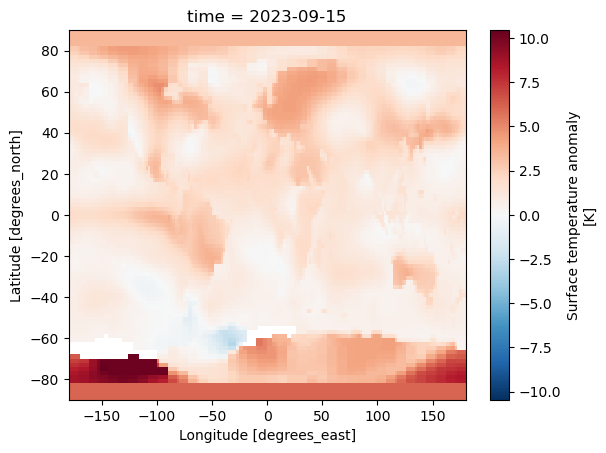

In [67]:
ds.tempanomaly.isel(time=-1).plot()

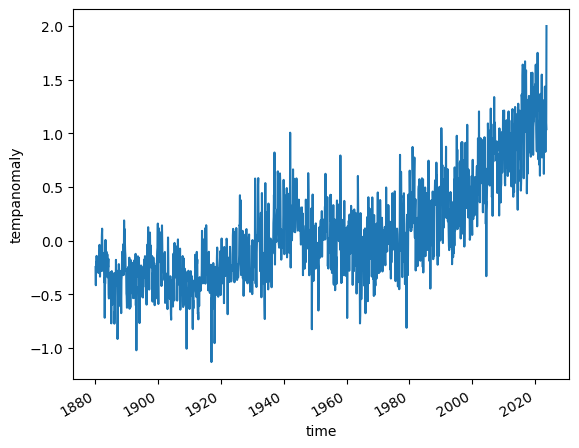

In [68]:
ds.tempanomaly.mean(dim=('lon', 'lat')).plot()

Let's visualize the temperature anomally for the grid near Worcester. (Worcester's coordinates: latitude: 42.2626; longtitude: -71.8023)

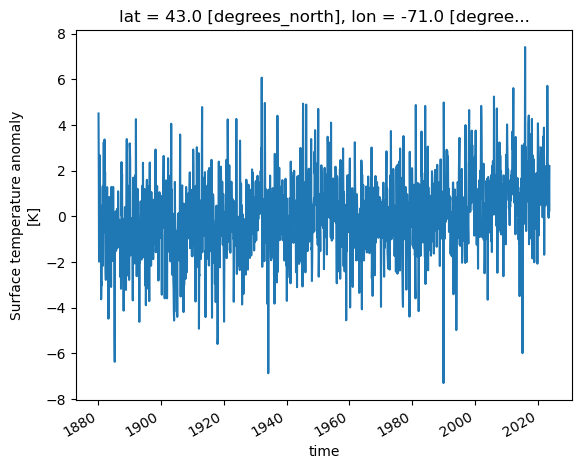

In [83]:
ds.tempanomaly.sel(lat=42.2626, lon=-71.8023, method='nearest').plot()

Note that you need to define `method` since the corresponding values for Worcester latitude and longitude do not exist in the `DataArray`'s coordinates. 